# 프로젝트 : CIFAR-10 이미지 생성하기
## 🎉fake accuracy가 추세적으로 0.5를 향해 하향 확인 성공!🎉
![graph06](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/graph08.PNG?raw=true)
***
###<목차>
##### STEP 0. GAN model 이란?
##### STEP 1. 작업환경 구성하기
##### STEP 2. 데이터셋 구성하기
##### STEP 3. 생성자 모델 구현하기
##### STEP 4. 판별자 모델 구현하기
##### STEP 5. 손실함수와 최적화 함수 구현하기
##### STEP 6. 훈련과정 상세 기능 구현하기
##### STEP 7. 학습 과정 진행하기
##### STEP 8. (optional) GAN 훈련 과정 개선하기
##### 🤔회고🤔
##### Reference

***
# STEP 0. GAN model 이란?
- GAN은 2014년에 처음 나왔으며, 생성모델 중 하나로 두 가지 네트워크를 가지고 있다.
  - Generator(생성자) : 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성
  - Discriminator(판별자) : 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real 인지, Fake 인지에 대한 판단 정도를 실숫값으로 출력

![GAN](https://d3s0tskafalll9.cloudfront.net/media/images/GAN.max-800x600.png)
- Generator는 Real같은 Fake를 잘 만들어내는 것이 목표이고, Discriminator는 Fake를 잘 판별하는 것이 목표이다.
  - 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
  - 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것
***
# STEP 1. 작업환경 구성하기


In [ ]:
# ! pip list | grep -E 'imageio|Pillow'

In [ ]:
# ! pip install imageio
# ! pip install Pillow

In [1]:
! mkdir -p /content/aiffel/dcgan_newimage/cifar10/generated_samples
! mkdir -p /content/aiffel/dcgan_newimage/cifar10/training_checkpoints
! mkdir -p /content/aiffel/dcgan_newimage/cifar10/training_history

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.8.0


# STEP 2. 데이터셋 구성하기

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 6s 0us/step


(50000, 32, 32, 3)

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


## 데이터 정규화 전

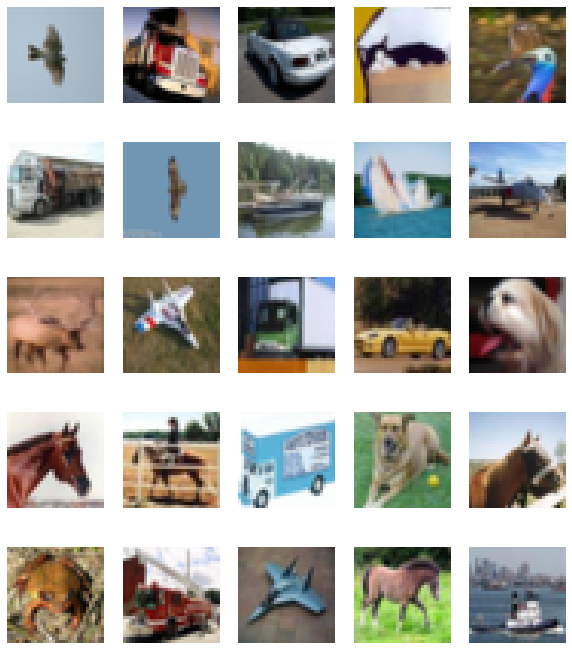

In [5]:
plt.figure(figsize=(10, 12))

for i in range(25):
    # [[YOUR CODE]]
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3), cmap='gray')
    plt.axis('off')

plt.show()

## 데이터 정규화

In [6]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [7]:
#데이터 shape 살펴보기
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


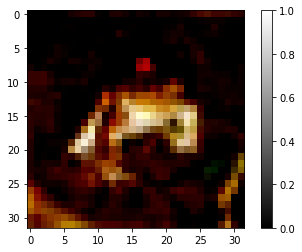

In [ ]:
#데이터 생김새 확인하기
plt.imshow(train_x[0].reshape(32, 32, 3), cmap='gray')
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

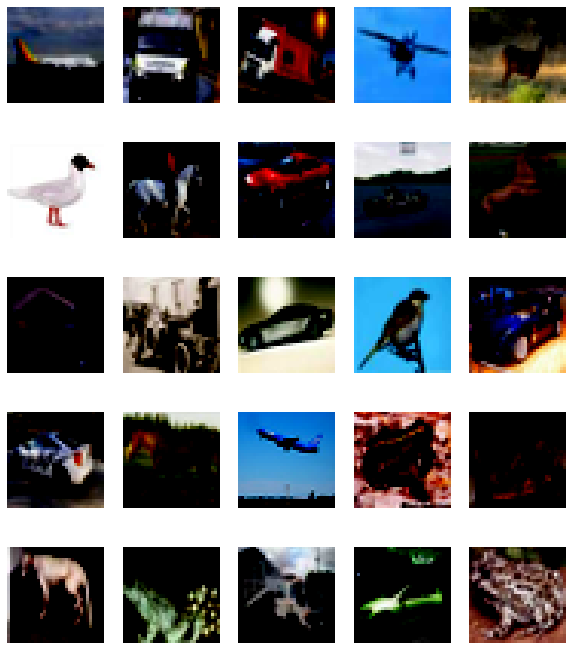

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    # [[YOUR CODE]]
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3), cmap='gray')
    plt.axis('off')

plt.show()

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

#train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고,
#이를 배치 사이즈에 따라 나누도록 함
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float64, name=None)>

# STEP 3. 생성자 모델 구현하기⭐
-  `tf.keras.Sequential()` 로 모델을 시작한 후 레이어 쌓기
-  `Conv2DTranspose` : 이미지 사이즈를 넓혀주는 층
- ` BatchNormalization` : 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화
- 중간층들의 활성화 함수는 모두 `LeakyReLU`를 사용
- 마지막 층에는 활성화 함수로 `tanh`를 사용하는데, 이는 우리가 -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함

In [11]:
 def make_generator_model(in_shape=(32, 32, 3)):

     # Start
     model = tf.keras.Sequential()

     # First: Dense layer
     model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
     model.add(layers.BatchNormalization(momentum = 0.99))
     model.add(layers.LeakyReLU(alpha=0.1))

     # Second: Reshape layer
     model.add(layers.Reshape((8, 8, 256)))

     # Third: Conv2DTranspose layer
     model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
     model.add(layers.BatchNormalization(momentum = 0.99))
     model.add(layers.LeakyReLU(alpha=0.1))

     # Fourth: Conv2DTranspose layer
     model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
     model.add(layers.BatchNormalization(momentum = 0.99))
     model.add(layers.LeakyReLU(alpha=0.1))

     # Fifth: Conv2DTranspose layer
     model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                      activation='tanh'))

     return model

In [12]:
 generator = make_generator_model()

 generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [ ]:
# def make_generator_model(in_shape=(32, 32, 3)):

#     # Start
#     model = tf.keras.Sequential()

#     # First: Dense layer
#     model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
#     model.add(layers.BatchNormalization(momentum = 0.99))
#     model.add(layers.LeakyReLU(alpha=0.1))

#     # Second: Reshape layer
#     model.add(layers.Reshape((4, 4, 512)))

#     # Third: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization(momentum = 0.99))
#     model.add(layers.LeakyReLU(alpha=0.1))

#     # Fourth: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization(momentum = 0.99))
#     model.add(layers.LeakyReLU(alpha=0.1))
    
#     # Fifth: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization(momentum = 0.99))
#     model.add(layers.LeakyReLU(alpha=0.1))

#     # Sixth: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
#                                      activation='tanh'))

#     return model

In [ ]:
# generator = make_generator_model()

# generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              819200    
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        3276800   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 256)        1

In [13]:
noise = tf.random.normal([1, 100])

In [14]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

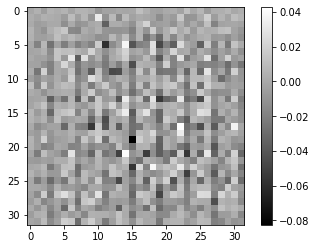

In [15]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
# plt.imshow(generated_image[0, :, :, 0], cmap='gray')
# plt.colorbar()
# plt.show()

In [ ]:
# plt.imshow(generated_image[0, :, :, 0], cmap='gray')
# plt.colorbar()
# plt.show()

# STEP 4. 판별자 모델 구현하기⭐
- `make_discriminator_model` 함수로 구현
- `Conv2D` : 이미지의 크기를 점점 줄여나감
- `Flatten` : 3차원 이미지를 1차원으로 쭉 펴서 벡터로 변환

In [ ]:
# def make_discriminator_model():

#     # Start
#     model = tf.keras.Sequential()

#     # First: Conv2D Layer
#     model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
# #    model.add(layers.BatchNormalization(momentum = 0.99))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.5))

#     # Second: Conv2D Layer
#     model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
# #    model.add(layers.Dropout(0.5))

#     # Third: Flatten Layer
#     model.add(layers.Flatten())

#     # Fourth: Dense Layer
#     model.add(layers.Dense(1))

#     return model

In [16]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fifth: Conv2D Layer
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Sixfth: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.6))

    # Seventh: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 4, 4, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 512)        

In [18]:
# 아까 생성한 가짜 이미지 입력!
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49992085]], dtype=float32)>

# STEP 5. 손실함수와 최적화 함수 구현하기
## 손실함수
- GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용   
  => 점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 사용

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
#generator_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
#discriminator_loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [22]:
#discriminator accuracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 최적화 함수

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [24]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# STEP 6. 훈련과정 상세 기능 구현하기

In [25]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- -1~1 사이로 정규화했던 데이터 셋을 다시 돌려놓는다.

In [26]:
def generate_and_save_images(model, epoch, it, sample_seeds, dirno=1):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
#        plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
#        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.imshow(np.array(predictions[i]*127.5 + 127.5).astype('uint8')) #(-1,1)로 정규화를 다시 (0,255)로
        plt.axis('off')
   
    plt.savefig('/content/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))
#    plt.savefig('/content/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
#                    .format(os.getenv('HOME'), epoch, it))


    plt.show()

In [27]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(epoch))
#    plt.savefig('/content/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
#                    .format(os.getenv('HOME'), epoch))
    plt.show()

###체크포인트

In [28]:
checkpoint_dir = '/content/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP 7. 학습 과정 진행하기

In [29]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [30]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

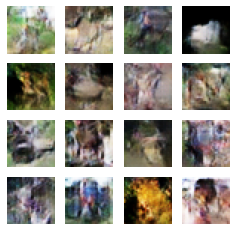

Time for training : 3007 sec


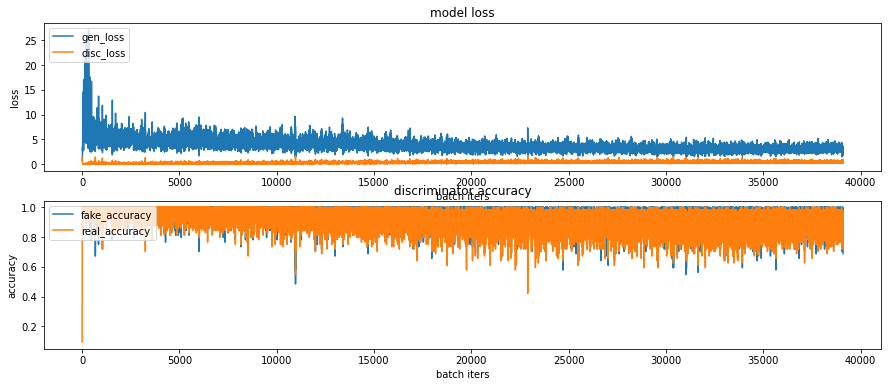

CPU times: user 17min 25s, sys: 49.1 s, total: 18min 14s
Wall time: 50min 10s


In [31]:
%%time
train(train_dataset, EPOCHS, save_every)

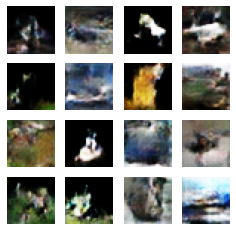

Time for training : 2991 sec


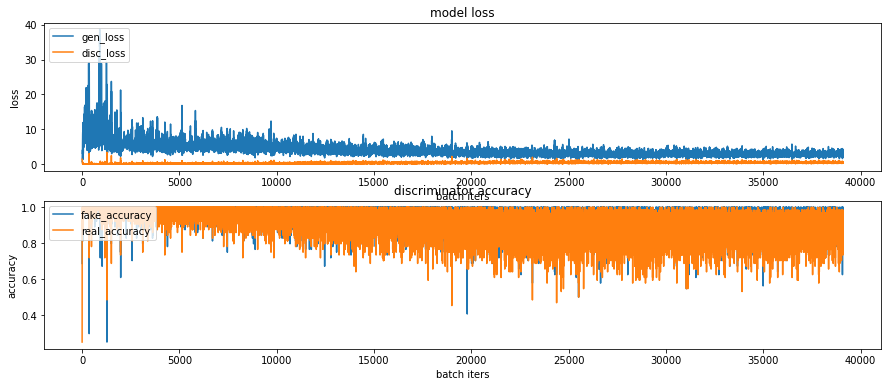

CPU times: user 18min 17s, sys: 55.5 s, total: 19min 12s
Wall time: 49min 53s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

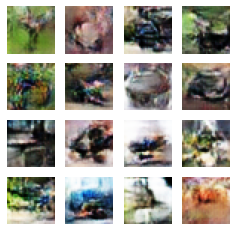

Time for training : 1661 sec


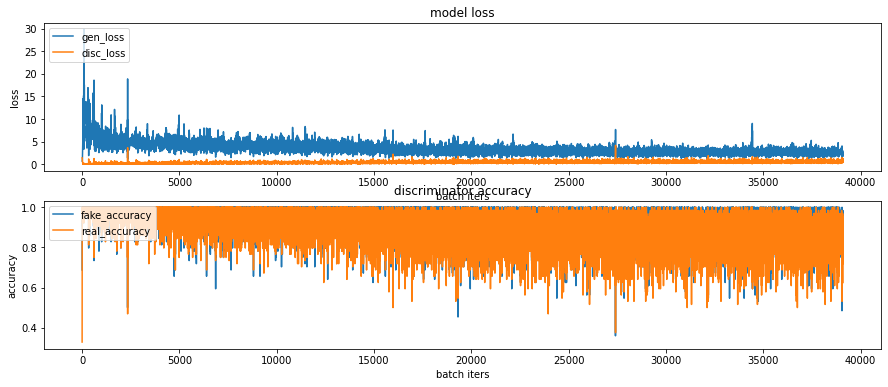

CPU times: user 15min 56s, sys: 33.8 s, total: 16min 30s
Wall time: 27min 43s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

#### 📌생각📌
- 그래프를 보면서 환호했다.
- 이번 주제에서 특히나 fake accuracry가 0.5를 향해 하향하고 있음을 증명하기는 굉장히 어렵다고 들었다. 그래서 나도 별 기대를 안했는데 중요 지표들을 수정하니 loss도 꾸준히 하향하면서 fake accuracry도 0.5를 향해 하향하고 있음을 볼 수가 있다!!!!!

### 학습과정 시각화

In [32]:
anim_file = '/content/aiffel/dcgan_newimage/cifar10/CIFAR_11.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format())
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l /content/aiffel/dcgan_newimage/cifar10/CIFAR_11.gif

-rw-r--r-- 1 root root 2534180 Feb 15 18:44 /content/aiffel/dcgan_newimage/cifar10/CIFAR_11.gif


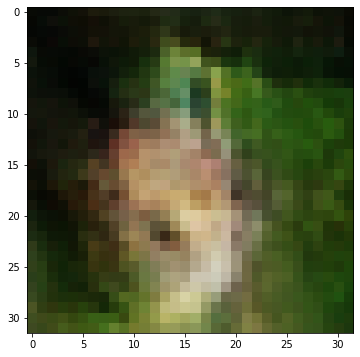

In [36]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

# STEP 8. (optional) GAN 훈련 과정 개선하기
## 개선사항 및 학습 과정 보기

|   NO    |변경사항|문제점 및 분석|gif|
|---|---|---|---|
|01|base code|기존 code를 그대로 사용하였더니 컬러 이미지임에도 흑백 결과가 나왔다.|![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_01.gif?raw=true)width="30" height="30"|
|02|STEP6에서 정규화를 다시 역정규화 시켜줌|컬러 전환 완료|![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_02.gif?raw=true)width="30" height="30"|
|03|  BatchNormalization 0.99 </br> dropout 0.5 설정|좀 더 선명해진 느낌...?|![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_03.gif?raw=true)width="30" height="30"|
|04|BATCH_SIZE = 256 => BATCH_SIZE = 128 </br> dropout제거|위에 버전보다는 나름 형태가 보이는 듯(?)하다. 내 느낌인가..?   </br>여튼 모델이 deep할 수록 성능이 개선된다고 하기에 model layer을 추가해주고 싶다.|![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_04.gif?raw=true)width="30" height="30"|
|05|Generator model layer 쌓기 </br> LeakyReLU alpha=0.1 설정(일반적으로 0.01로 설정한다고 함)|갑자기 colab에서 gpu 용량 부족으로 안된단다..</br>결국 colab 결제를 하고 돌리는데 실수로 전부 초기화를 해서 일부러 남겨뒀던 기록들이 날아갔다ㅠ </br>그래서 layer 쌓은 이후부터의 기록만 남아있는데 위에서 건드린 다른 요소들을 원래대로 돌려봐야할 것 같다.|![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_05.gif?raw=true)width="30" height="30"|
|06|LeakyReLU(alpha=0.1)로 수정|아무래도... Generation model layer 쌓은 건 좋은 방법이 아니었던 것 같다.|![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_06.gif?raw=true)width="30" height="30"|
|07|Discriminator model layer 쌓기|Generation model을 원래대로 돌리고 대신 Discriminator model layer를 늘리니 4와 비슷하게 보인다.</br> 아무래도 Generator model layer를 늘리면 그만큼 Discriminator model layer도 훨씬 늘어나야 좋은 성능을 기대할 수 있을 것 같다. |![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_07.gif?raw=true)width="30" height="30"|
|08|BATCH_SIZE = 128 => BATCH_SIZE = 64</br>Discriminator model layer 더 늘리기|⭐실사진의 느낌처럼 형태가 보이기 시작함 </br> ⭐가장 중요한건!!! Graph를 보면 매우 유의미한 결과가 나왔는데, loss는 점점 줄어들고 fake accuracry는 점진적으로 0.5에 가까워지는 것이 그래프를 통해 매우 잘 보인다!!!!!!!!!!!!!!!!|![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_08.gif?raw=true)width="30" height="30"|
|09|LeakyReLU alpha=0.1 => LeakyReLU alpha=0.2</br>Epochs=50 => Epochs=70|06번째 실험에서 아무래도 LeakyReLU의 기울기 조정은 긍정적인 영향을 미쳤을 가능성이 높았기에 alpha=0.2로 조절해주었다. </br> Graph를 보았을 때 Epochs는 50으로 유지하는 것이 좋다.| ![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_09.gif?raw=true)width="30" height="30"|
|10|Generator LeakyReLU alpha=0.2 => LeakyReLU alpha=0.1</br>Discriminator dropout 0.5설정 </br>Epochs=70 => Epochs=50|LeakyReLU는 0.1로 두는게 가장 좋은 것 같다. </br> 이번 실험도 Graph 상으로는 상당히 나쁘지 않은 결과를 나타냈지만 이미지들이 마치 정규화된 것처럼 출력이 되었다. </br> 위로 올라가 다시 살펴보니 정규화 했을 때 이미지들이 1~9실험 때보다 훨씬 새카맣게 탄 것처럼 보였다. 실험을 연속으로 진행하면서 중간에 뭔가 잘못된 것일까? </br> LeakyReLU alpha=0.1로 다시 설정하고 마지막 실험을 진행해야겠다. | ![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_10.gif?raw=true)width="30" height="30"|
|10|LeakyReLU 모두 alpha=0.1 </br>Discriminator dropout 0.6설정(가장 효과적이라고 함)|선명하진 않지만 대략적인 형태가 보임| ![Alt Text](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_11.gif?raw=true)width="30" height="30"|



## Graph 보기

|NO |사진|NO|사진|
|---|---|---|---|
|01|![graph01](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/graph01.PNG?raw=true)|02|![graph01](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/graph02.PNG?raw=true)|
|03|![graph01](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/graph02.PNG?raw=true)|04|![graph04](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/graph04.PNG?raw=true)|
|05|![graph05](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/graph05.PNG?raw=true)|06|![graph06](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/graph06.PNG?raw=true)|
|07|![graph05](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/graph07.PNG?raw=true)|08|![graph06](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/graph08.PNG?raw=true)|
|09|![graph09](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/graph09.PNG?raw=true)|11|![graph11](https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/graph11.PNG?raw=true)|

## 분석
- 기본적으로 학습 이미지 자체가 화질이 좋지 않다.   
  따라서 결과 또한 흐릿하게 나왔지만 어느 정도 윤곽은 드러난다.
- 데이터가 워낙 많고 그래프 크기가 작아 지그재그 형태가 마치 색칠한 것처럼 보인다.   
  그래프가 작다는 점을 감안해서 보면 fake accuracy가 꾸준히 0.5로 우하향하는 것을 볼 수 있다.
- loss도 1~6번까진 굉장히 불안하다가 discriminator_model를 deep하게 해주니 안정된 모습을 보인다.   
  뿐만 아니라 fake accuracy의 우하향에도 상당히 효과적이었다.   
- discriminator_model이 deep할 수록 좋다.   
  dropout은 최소한으로 사용하는 것이 좋다.   
  batch size 64~128 사이가 효과적이다.   

<img src="https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_11.gif?raw=true" width="500" height="500">
<img src="https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/CIFAR_08.gif?raw=true" width="500" height="500">
<img src="https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/graph_final01.PNG?raw=true" width="1000" height="500">
<img src="https://github.com/LAGABI44/AIFFEL_Study/blob/LMS/EXPLORATION/Submission/%5BE-10%5D/graph_final02.PNG?raw=true" width="1000" height="500">

### ❗주의❗ 보라색선 착시 현상으로 인해 위로 올라간 것처럼 보이는데 y=0.5 축 맞습니다.

# 🤔회고🤔
### <루브릭 평가 지표>
|   평가문항    |상세기준|
|---|---|
|1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.|
|2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.|gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.|
|3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.|

***
### <이번 프로젝트에서 어려웠던 점>
- 어려웠다기보다는 그냥 재밌었다.
- 원하는만큼의 결과를 내기까지 오랜 시간이 걸렸을 뿐!

***
### <프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점>
1. BatchNormalization와 Dropout 적용   
(1) BatchNormalization   
- BatchNormalization는 Convoluter Layer 또는 Fully Connected Layer 등의 layer 뒤에 적용되는 것이 좋다.
- ReLU와 같은 Activation function을 적용하기 전에 적용하는 것을 추천
- alpha는 Momentum이란 계수로 보통 0.9, 0.99, 0.999와 같이 1에 가까운 값을 사용함   
(2) Dropout   
- Dropout은 activation function을 적용한 뒤에 적용하는 것이 좋다.

2. Batch size
- Batch size는 크면 클수록 성능이 좋아지는 경향이 있음
- 다만 1024를 넘어갈 경우 overfitting의 가능성이 높아짐
- GAN 모델의 경우 overfitting에 있어 훨씬 민감함 따라서 Batch size를 128 이하로 사용하는 것을 권장하며, 여러 번 실험시 64일 때가 가장 효과적

3. Generative Model과 Discriminative Model
- Discriminative Model의 layer를 추가를 할 때마다 좋은 성능을 보여준다.
- 당연한 말이지만 layer 추가도 남용하며 너무 deep하게 들어가버리면 overfitting으로 안하는 것만도 못하는 결과가 나올 것이다.

***
### <루브릭 평가 지표를 맞추기 위해 시도한 것들>
1. 기본적으로 GAN 모델이 굉장히 까다로우며 여러가지를 고려해야한다는 특성을 가지고 있다. 따라서 나는 어느 한가지 지표만을 향상시키기보다는(overfitting 문제 때문에도 꺼림) 여러 유의미한(영향력이) 큰 지표들 위주로 수정해보고자 했다.
2. 모델 깊이 deep하게 하기   
=> Generative Model과  Discriminative Model 모두 layer를 추가해보았다.
  Generative Model의 경우 layer 추가하였을 때 오히려 이미지가 더 뿌얘지는 상황을 보았는데 해당 모델에 layer를 추가할 경우 Discriminative Model 또한 같이 layer 추가를 해주어야 기본값을 하는 것 같았다.
=> Discriminative Model의 layer를 추가하고 Generative Model layer를 기본값으로 돌리니 상향이 좋은 결과를 보였다.
3. BATCH_SIZE 조절  
4. LeakyReLU 기울기 조절
5. Epochs 조절 => 좀 더 충분한 학습

***
### <만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정>
- 기본적으로 데이터의 화질이 굉장히 낮았다. input이 좋지 않으니 output도 좋지 않는게 당연...    
선명한 output을 위해 선명한 input이 있었으면 더욱 좋았을 것 같다.

***
### <자기 다짐>
- 매일 새롭게 접하는 이론들이 많은데 이를 꾸준하게 정리할 수 있는 방법을 찾아야겠다.
- 각 모델의 layer에 대해 좀 더 깊게 이해하도록 노력해야겠다.

# Reference
1. BatchNormalization, Dropout, Pooling 적용 순서 : https://gaussian37.github.io/dl-concept-order_of_regularization_term/
2. BatchNormalization momentum : https://junhyukso.github.io/post/bn_v1/
3. DCGAN Tuning Tips : https://seing.tistory.com/110
4. LeakyReLU Gradient : https://ardino.tistory.com/19
5. Dropout : https://m.blog.naver.com/laonple/220827359158